In [2]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import itertools
import random

# add path to model directory
sys.path.insert(0,'/home/sbose/out_there/FederatedPersonalizedLoadForecasting')

# load datas
data_CA = np.load('/home/sbose/out_there/FederatedPersonalizedLoadForecasting/NRELCAdataset.npz')['data']
data_IL = np.load('/home/sbose/out_there/FederatedPersonalizedLoadForecasting/NRELILdataset.npz')['data']
data_NY = np.load('/home/sbose/out_there/FederatedPersonalizedLoadForecasting/NRELNYdataset.npz')['data']

In [3]:
# necessary functions

from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

def generate_datetimes(start_dt, num_points):
    # list of datetimes
    start = datetime.strptime(start_dt, "%m:%d:%y-%H:%M:%S.%f")
    return [(start + timedelta(minutes=15 * i)).strftime("%Y-%m-%d %H:%M:%S.%f")[:-3] for i in range(num_points)]

def plot_subplots(data, dt, super_title, savepath):
    num_points, dim0 = data.shape
    datetimes = generate_datetimes(dt, num_points)
    
    fig, axs = plt.subplots(dim0, 1, figsize=(10, 3 * dim0))
    fig.suptitle(super_title, bbox=dict(facecolor='white', edgecolor='black'))
    
    for i in range(dim0):
        axs[i].plot(range(num_points), data[:, i])
        axs[i].set_ylabel(f"{i}th quantity")
        axs[i].set_xlabel("index")
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].set_xticks(range(0, num_points, max(1, num_points // 10)))  # Set fewer x-ticks
        axs[i].set_xticklabels([datetimes[j] for j in axs[i].get_xticks()])  # Replace specific ticks with datetime strings
        axs[i].set_xlim(0, num_points - 1)  # Set xlims precisely
        axs[i].grid(True)  # Add grid
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(savepath,format=savepath.split('.')[-1],bbox_inches='tight')
    return fig, axs

def moving_average(data, window_size):
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='same')
    return moving_avg

def set_seed(seed=233):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# initialize a model and write a dataset class

from torch.utils.data import Dataset, DataLoader
from models.DARNN import DARNN

# write a dataset for the class

class NRELComstock(Dataset):
    
    def __init__(
        self,
        data_array: np.ndarray,
        num_bldg: int = 12,
        lookback: int = 12,
        lookahead:int = 4,
        normalize: bool = True,
        dtype: torch.dtype = torch.float32,
        mean: np.ndarray = None,
        std: np.ndarray = None
    ):
        
        if data_array.shape[0] < num_bldg:
            raise ValueError('More buildings than present in file!')
        else:
            self.data = data_array[:num_bldg,:,:]
        self.num_clients = num_bldg
        
        # lookback and lookahead
        self.lookback, self.lookahead = lookback, lookahead
        
        # Calculate statistics
        stacked = self.data.reshape(self.data.shape[0]*self.data.shape[1],self.data.shape[2])
        if (mean is None) or (std is None):
            self.mean = stacked.mean(axis=0,keepdims=True)
            self.std = stacked.std(axis=0,keepdims=True)
        else:
            self.mean = mean
            self.std = std
        self.ndata = (self.data-self.mean)/self.std # normalized data
        
        # disambiguating between clients
        len_per_client = self.data.shape[1] - lookback - lookahead + 1
        self.total_len = len_per_client * self.num_clients
        self.splits = np.array_split(np.arange(self.total_len),self.num_clients)
        
        # save whether to normalize, and the data type
        self.normalize = normalize
        self.dtype = dtype
        
    def _client_and_idx(self, idx):
        
        part_size = self.total_len // self.num_clients
        part_index = idx // part_size
        relative_position = idx % part_size
        
        return relative_position, part_index
    
    def __len__(self):
        
        return self.total_len
    
    def __getitem__(self, idx):
        
        tidx, cidx = self._client_and_idx(idx)
        
        if self.normalize:
            x = self.ndata[cidx,tidx:tidx+self.lookback,:]
            y = self.ndata[cidx,tidx+self.lookback+self.lookahead-1,[0]]
        else:
            x = self.data[cidx,tidx:tidx+self.lookback,:]
            y = self.data[cidx,tidx+self.lookback+self.lookahead-1,[0]]
            
        x,y = torch.tensor(x,dtype=self.dtype), torch.tensor(y,dtype=self.dtype)
        
        return x,y
        
class Loss(nn.Module):
    def __init__(
        self
    ):
        super(Loss,self).__init__()
        self.loss = nn.MSELoss(reduction='mean')
        
    def forward(self, pred, target):
        
        return self.loss(pred,target)
    
class MAPE:
    def __init__(
        self,
        dataset = None,
        normalize = True
    ):
        
        self.mean = dataset.mean[0,0].item()
        self.std = dataset.std[0,0].item()
        self.normalize = normalize
        
    def forward(self, pred, target):
        
        if self.normalize:
            pred = self.std*pred + self.mean # inverse transform
            target = self.std*target + self.mean # inverse transform
        
        num = torch.abs(pred-target)
        den = torch.abs(target)
        
        return 100 * torch.mean(num/den).detach().cpu().numpy().item()
    
def infinity_norm_of_grads(model: nn.Module) -> float:
    max_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            max_norm = max(max_norm, torch.max(torch.abs(param.grad)).item())
    return max_norm
            

In [5]:
# get the numbers
num_clients = 42
batch_size = 512
device = 'cuda'
steps = 60000
lr = 1e-3
test_every = 1000
ttr = 0.8
display_time_idx = 250
seed = 42

# load the dataset
set_seed(seed)
dset = NRELComstock(
    data_NY[:,:int(ttr*data_NY.shape[1]),:],
    num_bldg=num_clients,
    lookback = 12,
    lookahead = 4,
    normalize = True,
    dtype = torch.float32
)
dset_test = NRELComstock(
    data_NY[:,int(ttr*data_NY.shape[1]):,:],
    num_bldg=num_clients,
    lookback = 12,
    lookahead = 4,
    normalize = True,
    dtype = torch.float32,
    mean = dset.mean,
    std = dset.std
)
loader = DataLoader(dset, batch_size=batch_size,shuffle=True)
loader_test = DataLoader(dset_test, batch_size=1024,shuffle=False)
loss = Loss()
mape = MAPE(dset,True)
model = DARNN(
    input_size = 8,
    hidden_size = 30,
    seq_len = 12,
    num_lstm_layers = 2,
    dtype = torch.float32
).to(device)
optim = torch.optim.SGD(model.parameters(),lr=lr)

In [6]:
loss_record, grad_record, mape_record = [], [], []

step, last_mape = 0, np.nan
set_seed(seed)
for inp,label in (t:=tqdm(itertools.cycle(loader))):
    
    inp,label = inp.to(device), label.to(device)
    lossval = loss(model(inp),label)
    optim.zero_grad()
    lossval.backward()
    grad_record.append(infinity_norm_of_grads(model))
    optim.step()
    loss_record.append(lossval.item())
    step +=1 
    
    if step % test_every == 0:
        inp_test, out_test = next(iter(loader_test))
        inp_test, out_test = inp_test.to(device), out_test.to(device)
        mapeval = mape.forward(model(inp_test),out_test)
        mape_record.append(mapeval)
        last_mape = mapeval
        
    t.set_description(f"Loss is {lossval.item()}, last MAPE was {last_mape}.")
    
    if step == steps:
        break
    

Loss is 0.02722344920039177, last MAPE was 15.891991555690765.: : 59999it [42:51, 23.33it/s] 


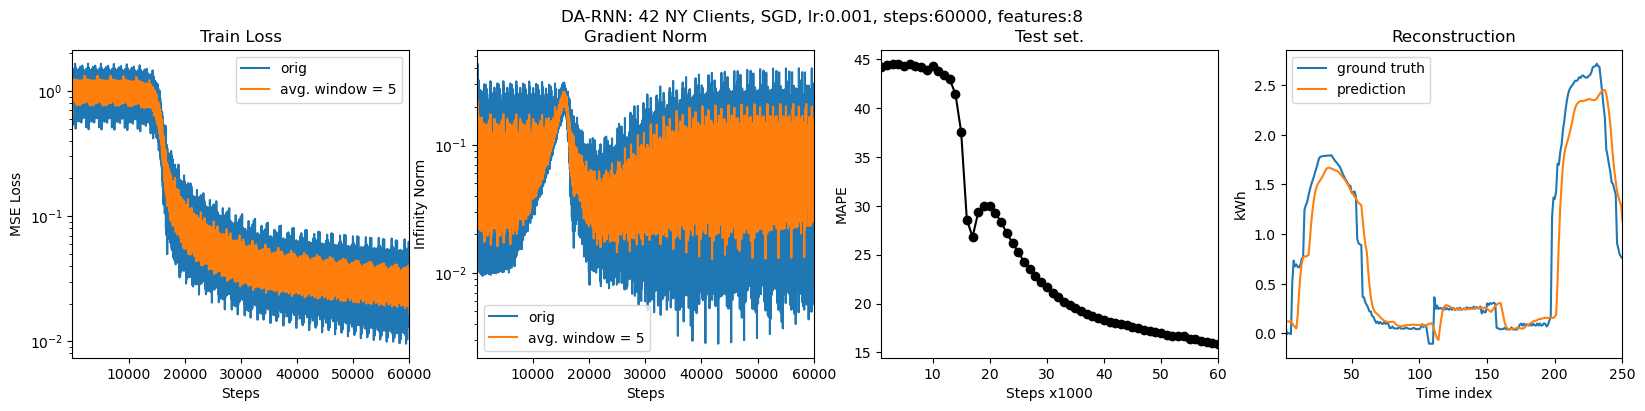

In [8]:
# save and plot results

# plotting here
fig, axs = plt.subplots(1, 4, figsize=(20,4))
# plot losses
loss_record = np.array(loss_record)
axs[0].plot(np.arange(1,loss_record.size+1),np.array(loss_record),label='orig')
axs[0].plot(np.arange(1,loss_record.size+1),moving_average(np.array(loss_record),5),label='avg. window = 5')
axs[0].set_xlim(1,loss_record.size)
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('MSE Loss')
axs[0].set_title(f'Train Loss')
axs[0].legend()
axs[0].set_yscale('log')
# plot norms
grad_record = np.array(grad_record)
axs[1].plot(np.arange(1,grad_record.size+1),np.array(grad_record),label='orig')
axs[1].plot(np.arange(1,grad_record.size+1),moving_average(np.array(grad_record),5),label='avg. window = 5')
axs[1].set_xlim(1,grad_record.size)
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Infinity Norm')
axs[1].set_title(f'Gradient Norm')
axs[1].legend()
axs[1].set_yscale('log')
# plot MAPEs
mape_record = np.array(mape_record)
axs[2].plot(np.arange(1,mape_record.size+1),np.array(mape_record),'ko-')
axs[2].set_xlim(1,mape_record.size)
axs[2].set_xlabel(f'Steps x{test_every}')
axs[2].set_ylabel(f'MAPE')
axs[2].set_title(f'Test set.')
# plot the test sets
inputs, outputs = [], []
for idx in range(display_time_idx):
    itm = dset_test.__getitem__(idx)
    inputs.append(itm[0])
    outputs.append(itm[1].numpy())
batched_input = torch.stack(inputs).to(torch.float32).to(device)
with torch.no_grad():   
    batched_output = model(batched_input).to('cpu').numpy()
preds = list(batched_output)
plot_gt, plot_pred = [], []
for idx in range(display_time_idx):
    # z normalization
    plot_gt.append(outputs[idx][0])
    plot_pred.append(preds[idx][0])
plot_gt, plot_pred = np.array(plot_gt), np.array(plot_pred)
axs[3].plot(np.arange(1,plot_gt.size+1),plot_gt,label='ground truth')
axs[3].plot(np.arange(1,plot_pred.size+1),plot_pred,label='prediction')
axs[3].set_xlim(1,plot_pred.size)
axs[3].set_xlabel('Time index')
axs[3].set_ylabel('kWh')
axs[3].legend()
axs[3].set_title(f'Reconstruction')

fig.suptitle(f'DA-RNN: 42 NY Clients, SGD, lr:{lr}, steps:{steps}, features:8')

plt.savefig("/home/sbose/out_there/FederatedPersonalizedLoadForecasting/.results/pes_replicate_full_42.pdf",format="pdf",bbox_inches="tight")
torch.save(model.state_dict(),"/home/sbose/out_there/FederatedPersonalizedLoadForecasting/.results/pes_replicate_full_42.pth")
np.savez_compressed("/home/sbose/out_there/FederatedPersonalizedLoadForecasting/.results/pes_replicate_full_42.npz",loss_record=loss_record,grad_record=grad_record,mape_record=mape_record)